**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
# !curl -L $(yadisk-direct https://disk.yandex.ru/d/QPOw4hk84-se_w) -o data.zip

In [2]:
# !unzip data.zip >> /dev/null

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        image = image.astype(np.float32)
        sample = {'image': image, 'mask': mask}
        transformed = self.transform(image=sample['image'], mask=sample['mask'])
        sample['image'], sample['mask'] = transformed['image'].float(), transformed['mask'].unsqueeze(0).float()

        return sample

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_transform = A.Compose([
    A.RandomCrop(256, 256),
    # A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.GaussNoise(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(),
    ToTensorV2(),
])

In [4]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

test_transform = A.Compose([
    A.Resize(256, 256),
    ToTensorV2(),
])

In [5]:
train_dataset = RoadDataset(X_train, y_train, train_transform)

In [8]:
train_dataset[0]['image'].shape

torch.Size([3, 256, 256])

In [9]:
len(train_dataset)

648

In [10]:
X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")

In [11]:
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


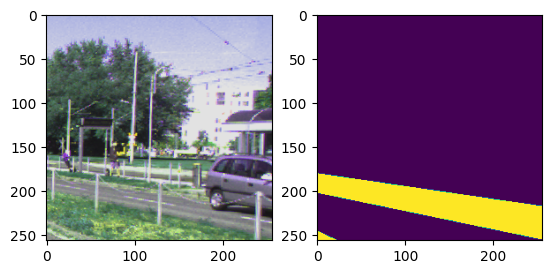

In [12]:
sample = train_dataset[20]
image = sample['image']
mask = sample['mask']

print(image.shape)
print(mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [13]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [14]:
from torch.utils.data import DataLoader

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

In [73]:
# unet_model = fcn_resnet50()

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        # x = self.relu(self.bn3(self.conv3(x)))
        return x

In [16]:
class ContractingPath(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.layer1 = ConvBlock(input_channels, 64)
        self.layer2 = ConvBlock(64, 128)
        self.layer3 = ConvBlock(128, 256)
        self.layer4 = ConvBlock(256, 512)
        self.layer5 = ConvBlock(512, 1024)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x1 = self.layer1(x)
        p1 = self.pool(x1)

        x2 = self.layer2(p1)
        p2 = self.pool(x2)

        x3 = self.layer3(p2)
        p3 = self.pool(x3)

        x4 = self.layer4(p3)
        p4 = self.pool(x4)

        x5 = self.layer5(p4)
        p5 = self.pool(x5)

        return x1, x2, x3, x4, x5, p5

In [17]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv = ConvBlock(in_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x, skip_connection):
        x = self.relu(self.bn(self.upconv(x)))
        x = torch.cat([x, skip_connection], dim=1)  # Concatenate along channels
        x = self.conv(x)  # ConvBlock already includes ReLU and BatchNorm
        return x

In [18]:
class ExpandingPath(nn.Module):
    def __init__(self):
        super(ExpandingPath, self).__init__()
        self.upconv5 = UpConvBlock(2048, 1024, 1024)
        self.upconv4 = UpConvBlock(1024, 1024, 512)
        self.upconv3 = UpConvBlock(512, 512, 256)
        self.upconv2 = UpConvBlock(256, 256, 128)
        self.upconv1 = UpConvBlock(128, 128, 64)

    def forward(self, features):
        x1, x2, x3, x4, x5, encoded = features
        x = self.upconv5(encoded, x5)
        x = self.upconv4(x, x4)
        x = self.upconv3(x, x3)
        x = self.upconv2(x, x2)
        x = self.upconv1(x, x1)
        return x


In [19]:
class Unet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.contract = ContractingPath(input_channels)
        self.expand = ExpandingPath()
        self.conv = nn.Conv2d(64, output_channels, kernel_size=1)

    def forward(self, x):
        x1, x2, x3, x4, x5, encoded = self.contract(x)
        x = self.expand((x1, x2, x3, x4, x5, encoded))
        x = self.conv(x)
        return x

In [79]:
unet_model = Unet(3, 3)

In [84]:
# mm = ContractingPath(3)

In [85]:
train_dataset[0]['image'].unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [86]:
unet_model(train_dataset[0]['image'].unsqueeze(0))

tensor([[[[ 0.3924,  0.3952,  0.2766,  ...,  0.1248, -0.1098,  0.0705],
          [ 0.3694, -0.0628, -0.1849,  ..., -0.1219, -0.0336, -0.0949],
          [ 0.1906, -0.1687,  0.0058,  ...,  0.1730,  0.2995, -0.0672],
          ...,
          [ 0.6127,  0.0426, -0.1493,  ...,  0.3370, -0.4412,  0.0611],
          [ 0.4127, -0.0080, -0.1890,  ..., -0.1753, -0.2566, -0.2746],
          [ 0.2242, -0.1079, -0.4125,  ..., -0.2633, -0.3786, -0.2825]],

         [[ 0.3342,  0.2508,  0.8151,  ...,  0.9232,  0.3320,  0.2221],
          [-0.1377,  0.1531,  0.2915,  ...,  0.2599, -0.1221,  0.5162],
          [ 0.1298,  0.4353,  0.3099,  ...,  0.4742, -0.0136,  0.0677],
          ...,
          [ 0.1597,  0.4919, -0.3407,  ..., -0.0492,  0.1065,  0.1408],
          [ 0.3560,  0.5823,  0.6372,  ...,  0.0566, -0.2283,  0.0817],
          [ 0.3041,  0.1057,  0.0530,  ...,  0.3693, -0.5470,  0.4076]],

         [[-0.4286, -0.6592, -0.3457,  ..., -1.0235, -0.4084, -0.4965],
          [-0.3086, -0.0409, -

In [87]:
unet_model = unet_model.to(device)

In [88]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=5e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [20]:
from IPython.display import clear_output
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    val_loss, train_loss = [], []
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_train_loss = 0
        model.train()  # train mode
        for batch in data_tr:
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)

            # Y_pred = Y_pred['out']
            # print(Y_batch.shape, Y_pred.shape)
            loss = loss_fn(Y_batch, Y_pred)
            # print(loss)
            loss.mean().backward()
            opt.step()

            # calculate loss to show the user
            avg_train_loss += loss.mean().item() / len(data_tr)
        print('Train loss: %f' % avg_train_loss)
        train_loss.append(avg_train_loss)

        # show intermediate results
        avg_test_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in data_val:
                X_batch, Y_batch = batch['image'], batch['mask']
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred = model(X_batch)
                # Y_pred = Y_pred['out']
                loss = loss_fn(Y_batch, Y_pred)
                avg_test_loss += loss.mean().item() / len(data_val)
            print('Test loss: %f' % avg_test_loss)
            val_loss.append(avg_test_loss)

            scheduler.step(avg_test_loss)
        #     # Visualize tools
            clear_output(wait=True)
            plt.figure(figsize=(18, 6))
            plt.plot(train_loss, label='train_loss')
            plt.plot(val_loss, label='val_loss')
            plt.legend()
            plt.show()

            batch = next(iter(data_val))
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            # Y_pred = Y_pred['out']
            Y_hat = torch.sigmoid(Y_pred.detach().cpu()) > 0.5
            
            m = X_batch.shape[0]
            plt.figure(figsize=(18, 6))
            for k in range(m):
                plt.subplot(2, m, k+1)
                plt.imshow(np.rollaxis(X_batch[k].cpu().numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')
                plt.subplot(2, m, k+1+m)
                plt.imshow(Y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_test_loss))
            plt.show()
        #     for k in range(6):
        #     plt.subplot(2, 6, k+1)
        #     plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        #     plt.title('Real')
        #     plt.axis('off')

        #     plt.subplot(2, 6, k+7)
        #     plt.imshow(Y_hat[k, 0], cmap='gray')
        #     plt.title('Output')
        #     plt.axis('off')
        # plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        # plt.show()

In [21]:
def bce_loss(y_real, y_pred):
    y_pred = y_pred
    loss = y_pred - y_real * y_pred + torch.log(1+torch.exp(-y_pred))
    return loss

def focal_loss(y_real, y_pred, alpha=0.25, gamma=2, eps=1e-8):
    # Apply sigmoid to y_pred
    sig_y_pred = torch.sigmoid(y_pred)
    
    # Loss for the positive examples
    pos_loss = -alpha * (1 - sig_y_pred)**gamma * y_real * torch.log(sig_y_pred + eps)
    
    # Loss for the negative examples
    neg_loss = -(1 - alpha) * sig_y_pred**gamma * (1 - y_real) * torch.log(1 - sig_y_pred + eps)
    
    # Combining both
    your_loss = pos_loss + neg_loss

    return torch.mean(your_loss)

def dice_loss(y_real, y_pred):
    """This definition generalize to real valued pred and target vector.
This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = y_pred.contiguous().view(-1)
    tflat = y_real.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

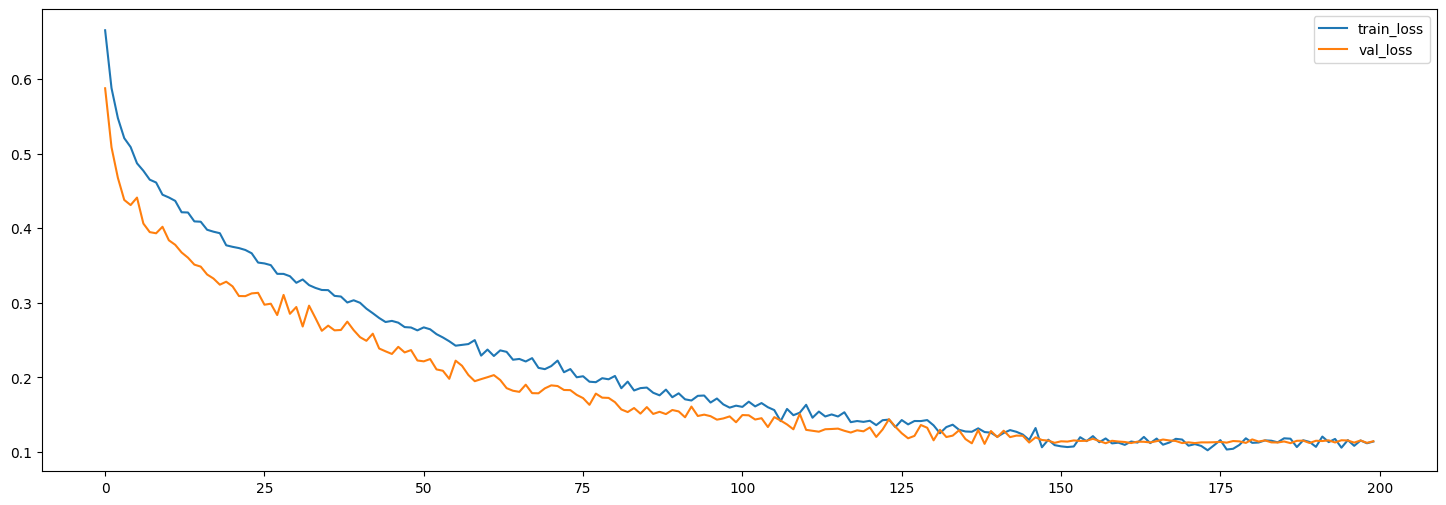

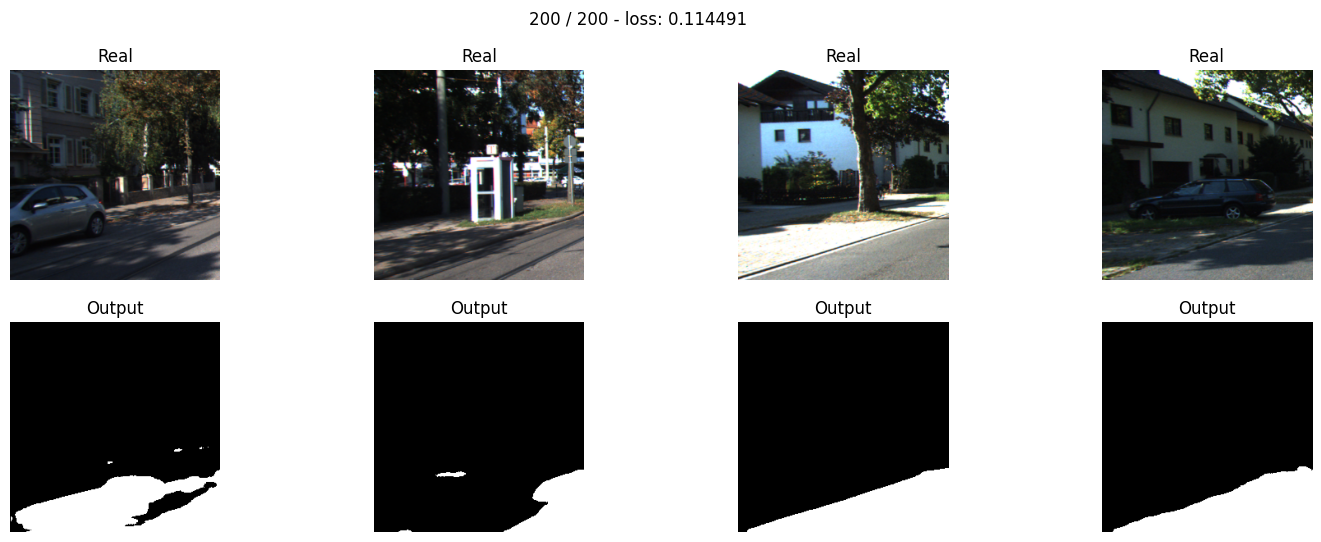

In [91]:
train(unet_model, optimizer, scheduler, bce_loss, 200, train_loader, val_loader)

In [92]:
# torch.save(unet_model.state_dict(), 'unet_hw2.pt')

In [22]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return intersection, union

In [23]:
def get_iou(model, val_loader):
    model.eval()
    total_intersection = 0
    total_union = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            # Y_pred = Y_pred['out']
            intersection, union = calc_iou(Y_pred.detach().cpu().numpy(), Y_batch.detach().cpu().numpy())
            total_intersection += intersection
            total_union += union
            print(f'Batch {i}: {intersection / union}')
    return total_intersection / total_union

In [95]:
get_iou(unet_model, val_loader)

Batch 0: 0.7415095049877659
Batch 1: 0.6630578447118296
Batch 2: 0.8484848484848485
Batch 3: 0.7772483105181078
Batch 4: 0.6356372762426694
Batch 5: 0.5639703176744757
Batch 6: 0.8345662187219488
Batch 7: 0.8740718344203653
Batch 8: 0.7656349850210521
Batch 9: 0.9201201357152748
Batch 10: 0.7052962596974346
Batch 11: 0.38775015300760995
Batch 12: 0.07236243474929362
Batch 13: 0.8103639679644754
Batch 14: 0.33544990733835894
Batch 15: 0.6571956334902574
Batch 16: 0.774233577344479
Batch 17: 0.7943445393328001
Batch 18: 0.9576917033312382
Batch 19: 0.9553948308827572
Batch 20: 0.9463217422401096
Batch 21: 0.905189589785924
Batch 22: 0.8790033912555174
Batch 23: 0.9069933096496132
Batch 24: 0.9670431670118403
Batch 25: 0.9622714196234071
Batch 26: 0.9295382228127542
Batch 27: 0.9370689475703439
Batch 28: 0.9405570622425535
Batch 29: 0.9283244476996713
Batch 30: 0.9002100385004906
Batch 31: 0.8761111991740176
Batch 32: 0.9510369498737319
Batch 33: 0.6131667386206838
Batch 34: 0.92731394948

0.8264764859573043

In [25]:
from torchvision.models import resnet152, ResNet152_Weights

In [26]:
resnet_101 = resnet152(ResNet152_Weights)

/home/misha/miniconda/envs/ml-311/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/misha/miniconda/envs/ml-311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv = ConvBlock(out_channels, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn(self.upconv(x)))
        x = self.conv(x)  # ConvBlock already includes ReLU and BatchNorm
        return x

In [29]:
class ExpandingPath(nn.Module):
    def __init__(self):
        super(ExpandingPath, self).__init__()
        self.upconv5 = UpConvBlock(2048, 1024)
        self.upconv4 = UpConvBlock(1024, 512)
        self.upconv3 = UpConvBlock(512, 256)
        self.upconv2 = UpConvBlock(256, 128)
        self.upconv1 = UpConvBlock(128, 64)
        self.upconv11 = UpConvBlock(64, 32)
        self.upconv12 = UpConvBlock(32, 16)
        self.upconv13 = UpConvBlock(16, 8)

    def forward(self, x):
        x = self.upconv5(x)
        x = self.upconv4(x)
        x = self.upconv3(x)
        x = self.upconv2(x)
        x = self.upconv1(x)
        x = self.upconv11(x)
        x = self.upconv12(x)
        x = self.upconv13(x)
        return x


In [31]:
class ResNet101AvgPool(nn.Module):
    def __init__(self, output_channels):
        super(ResNet101AvgPool, self).__init__()
        # Load the pretrained ResNet101 model
        self.resnet = resnet152(weights=ResNet152_Weights.DEFAULT)

        # Remove the fully connected layer (fc)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.expand = ExpandingPath()
        self.conv = nn.Conv2d(8, output_channels, kernel_size=1)

    def forward(self, x):
        x = self.resnet(x)
        # print(x.shape)
        x = self.expand(x)
        x = self.conv(x)
        return x

In [32]:
train_dataset[0]['image'].unsqueeze(0).shape

torch.Size([1, 3, 256, 256])

In [33]:
resnet_101(train_dataset[0]['image'].unsqueeze(0)).shape

torch.Size([1, 1000])

In [34]:
res_net_3 = ResNet101AvgPool(3).to(device)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /home/misha/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:21<00:00, 11.3MB/s] 


In [35]:
# res_net_3(train_dataset[0]['image'].unsqueeze(0)).shape

In [36]:
# unet_model(train_dataset[0]['image'].unsqueeze(0)).shape

In [37]:
optimizer = torch.optim.AdamW(res_net_3.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

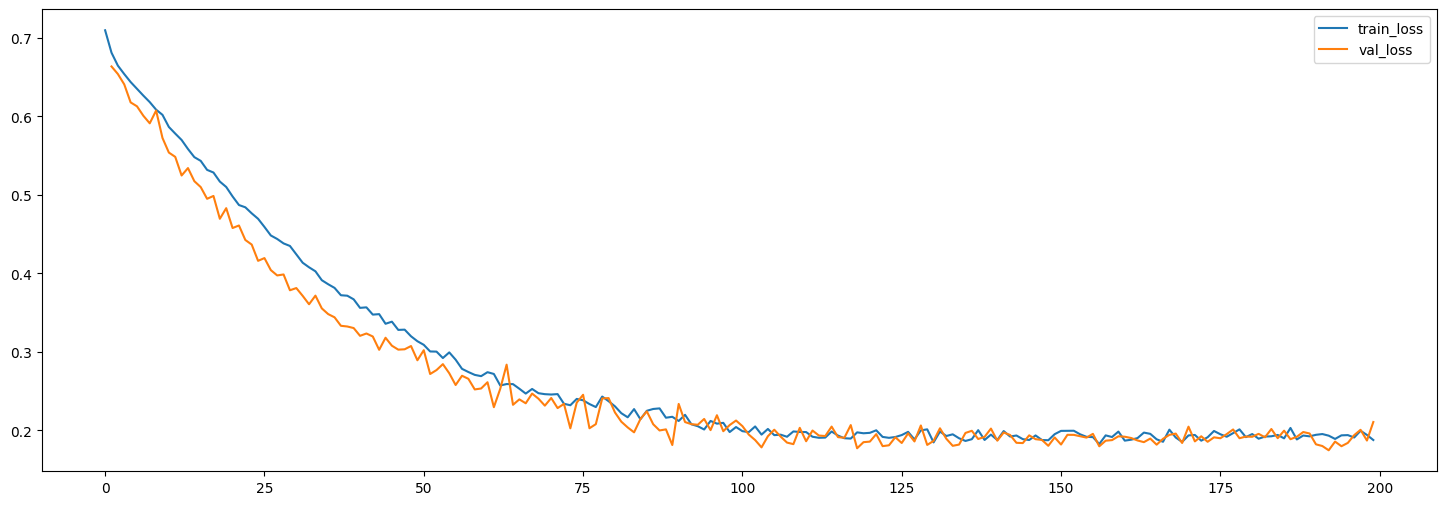

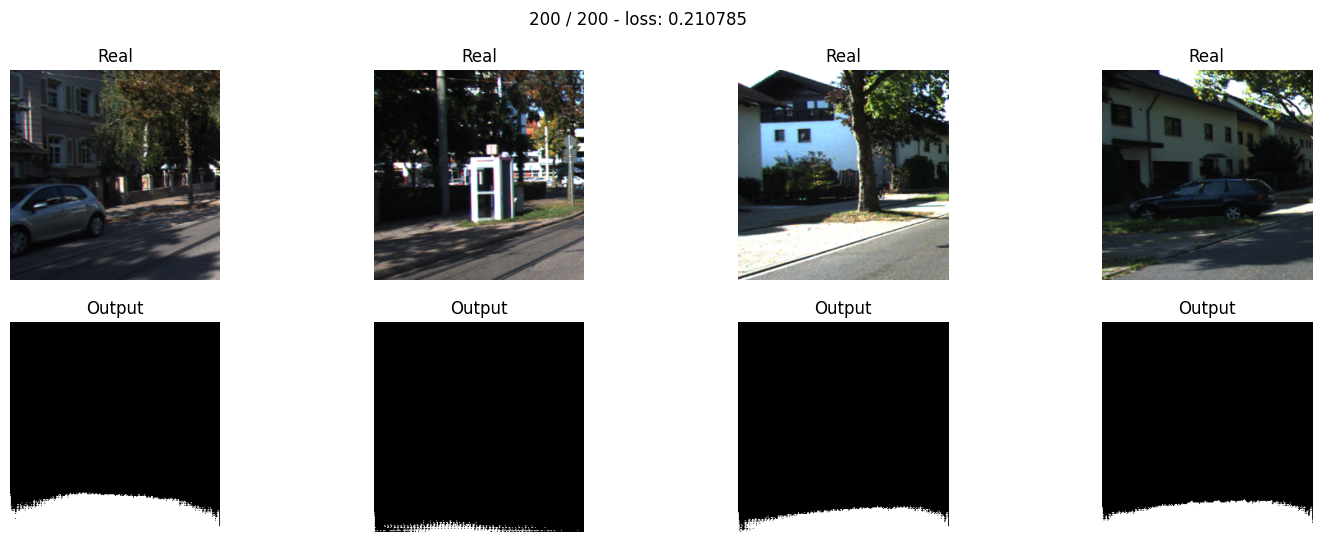

In [38]:
train(res_net_3, optimizer, scheduler, bce_loss, 200, train_loader, val_loader)

In [39]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return intersection, union

In [40]:
def get_iou(model, val_loader):
    model.eval()
    total_intersection = 0
    total_union = 0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            X_batch, Y_batch = batch['image'], batch['mask']
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            Y_pred = model(X_batch)
            # Y_pred = Y_pred['out']
            intersection, union = calc_iou(Y_pred.detach().cpu().numpy(), Y_batch.detach().cpu().numpy())
            total_intersection += intersection
            total_union += union
            print(f'Batch {i}: {intersection / union}')
    return total_intersection / total_union

In [41]:
get_iou(res_net_3, val_loader)

Batch 0: 0.4489737917473193
Batch 1: 0.5133247907152655
Batch 2: 0.15345714534833027
Batch 3: 0.11798307475317349
Batch 4: 0.28833369075702336
Batch 5: 0.34405627713558173
Batch 6: 0.053185522680533726
Batch 7: 0.5865737972900091
Batch 8: 0.5693515879569205
Batch 9: 0.6280677063044271
Batch 10: 0.6291032258064516
Batch 11: 0.0
Batch 12: 0.0
Batch 13: 0.27618373933418805
Batch 14: 0.3262434606074803
Batch 15: 0.0
Batch 16: 0.4206420801273547
Batch 17: 0.0
Batch 18: 0.692784685470893
Batch 19: 0.6946453403094819
Batch 20: 0.7486724712118384
Batch 21: 0.7347610678078353
Batch 22: 0.6907176452540498
Batch 23: 0.6938201632834151
Batch 24: 0.702696104385067
Batch 25: 0.7169429523202921
Batch 26: 0.681476518433108
Batch 27: 0.6599574336884517
Batch 28: 0.643670112878324
Batch 29: 0.5696661327509596
Batch 30: 0.528734058293491
Batch 31: 0.6082042319659613
Batch 32: 0.7343933485958805
Batch 33: 0.6886062912032959
Batch 34: 0.7543444839103006
Batch 35: 0.660679971554372
Batch 36: 0.4339127192958

0.5701232548424097